# **Chapter 2 – End-to-end Machine Learning project**

## Setup and Imports

In [199]:
import sys
assert sys.version_info >= (3, 7)

from packaging import version
import sklearn
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

from pathlib import Path
import pandas as pd
import numpy as np
import tarfile
import urllib.request
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics.pairwise import rbf_kernel

from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor

from sklearn.preprocessing import FunctionTransformer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.cluster import KMeans

In [51]:
# define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [52]:
IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)


## Helpers

In [53]:
def load_housing_data():
  tarball_path = Path("datasets/housing.tgz")
  if not tarball_path.is_file():
    Path("datasets").mkdir(parents=True, exist_ok=True)
    url = "https://github.com/ageron/data/raw/main/housing.tgz"
    urllib.request.urlretrieve(url, tarball_path)

    with tarfile.open(tarball_path) as housing_tarball:
      housing_tarball.extractall(path="datasets")

  return pd.read_csv(Path("datasets/housing/housing.csv"))

def income_cat_proportions(data):
  return data.income_cat.value_counts() / len(data)

## Get the Data

In [54]:
df = load_housing_data()

### Look at the data

In [55]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [57]:
df.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [58]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


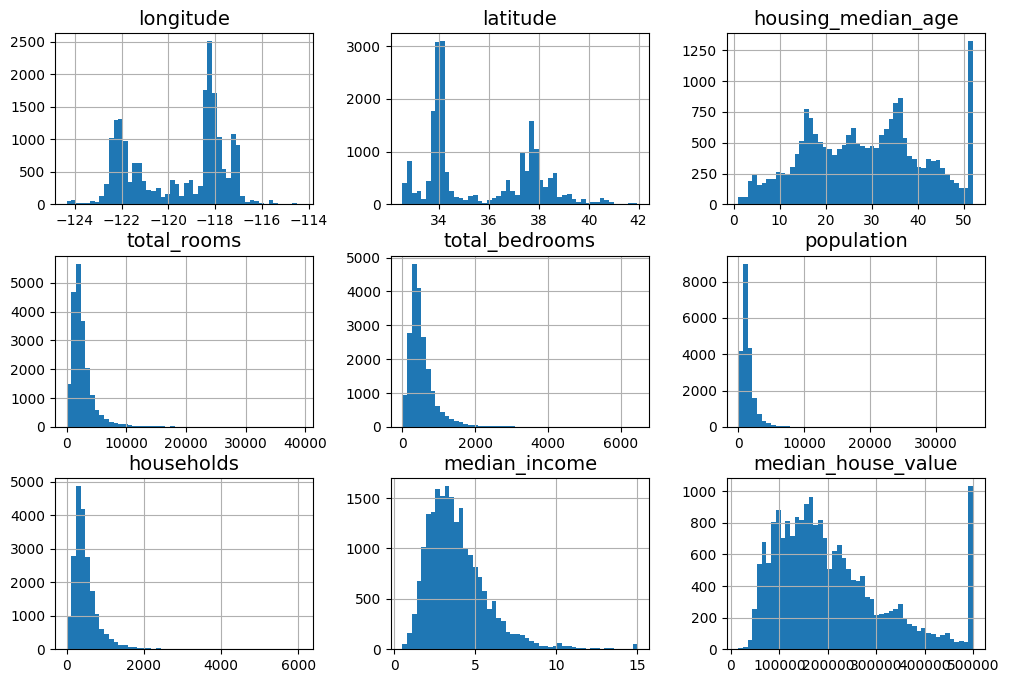

In [59]:
df.hist(bins=50, figsize=(12,8))
plt.show()

### Create a Test Set

In [60]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

To find the probability that a random sample of 1,000 people contains less than 48.5% female or more than 53.5% female when the population's female ratio is 51.1%, we use the [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution). The `cdf()` method of the binomial distribution gives us the probability that the number of females will be equal or less than the given value.

In [61]:
# extra code – shows how to compute the 10.7% proba of getting a bad sample

from scipy.stats import binom

sample_size = 1000
ratio_female = 0.511
proba_too_small = binom(sample_size, ratio_female).cdf(485 - 1)
proba_too_large = 1 - binom(sample_size, ratio_female).cdf(535)
print(proba_too_small + proba_too_large)

0.10736798530929913


Stratified split

E.g. income category is determined to be important.

In [62]:
df["income_cat"] = pd.cut(df["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

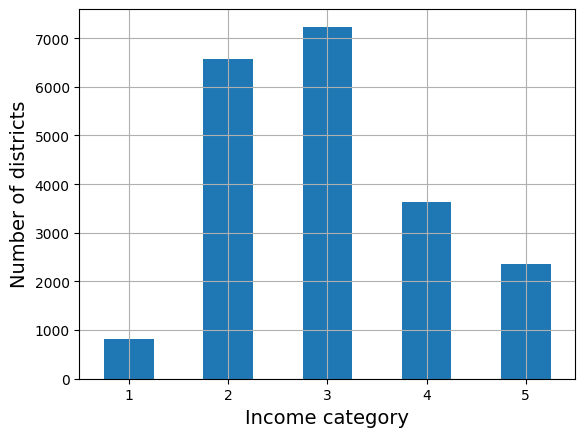

In [63]:
df["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [64]:
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []

for train_index, test_index, in splitter.split(df, df.income_cat):
  strat_train_set_n = df.iloc[train_index]
  strat_test_set_n = df.iloc[test_index]
  strat_splits.append([strat_train_set_n, strat_test_set_n])

strat_train_set, strat_test_set = strat_splits[0]

Alternatively you can use train_test_split

In [65]:
strat_train_set, strat_test_set = train_test_split(df, test_size=0.2, stratify=df.income_cat, random_state=42)

Lets compare the stratified examples

In [66]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(df),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(df_test),
})

compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)

(compare_props * 100).round(2).sort_values(by="Income Category")

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


In [67]:
# No longer need income_cat now
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Discover and Visualize the Data to Gain Insights

In [68]:
# Lets make a copy to experiments with transformations
df_train_copy = df_train.copy()

### Visualizing Geographical Data

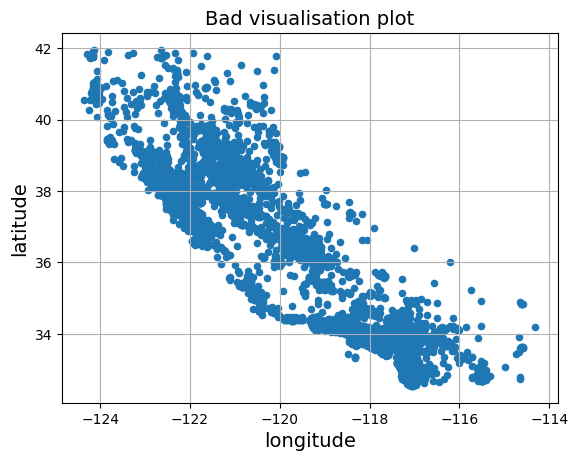

In [69]:
df_train_copy.plot(kind="scatter", x="longitude", y="latitude", grid=True)
plt.title("Bad visualisation plot")
plt.show()

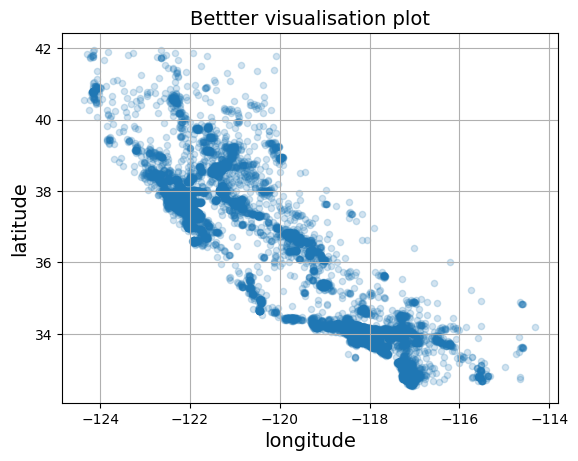

In [70]:
df_train_copy.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.title("Bettter visualisation plot")
plt.show()

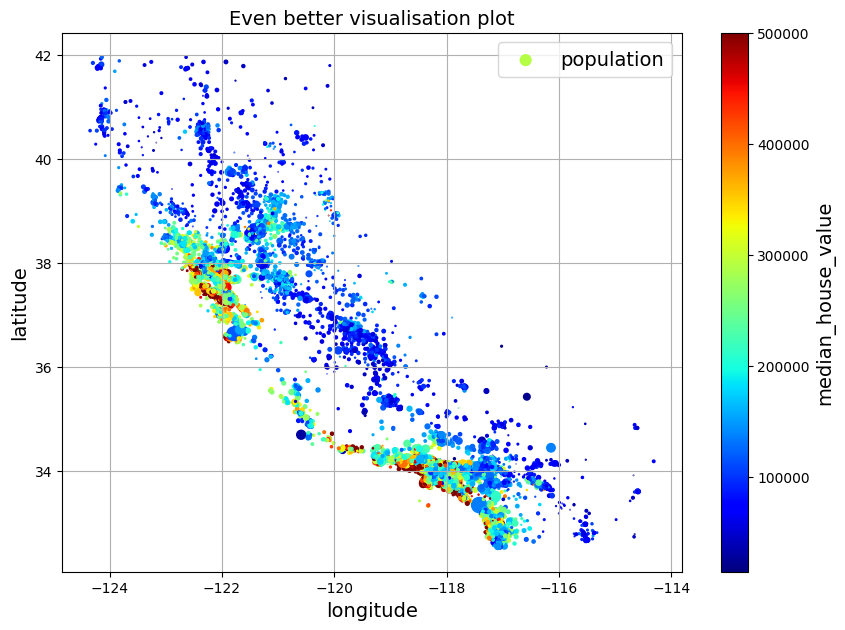

In [71]:
df_train_copy.plot(kind="scatter", x="longitude", y="latitude", grid=True,
                   s=df_train_copy.population / 300, label="population", c="median_house_value",
                   cmap="jet", colorbar=True, legend=True,  figsize=(10,7)
                   )

plt.title("Even better visualisation plot")
plt.show()

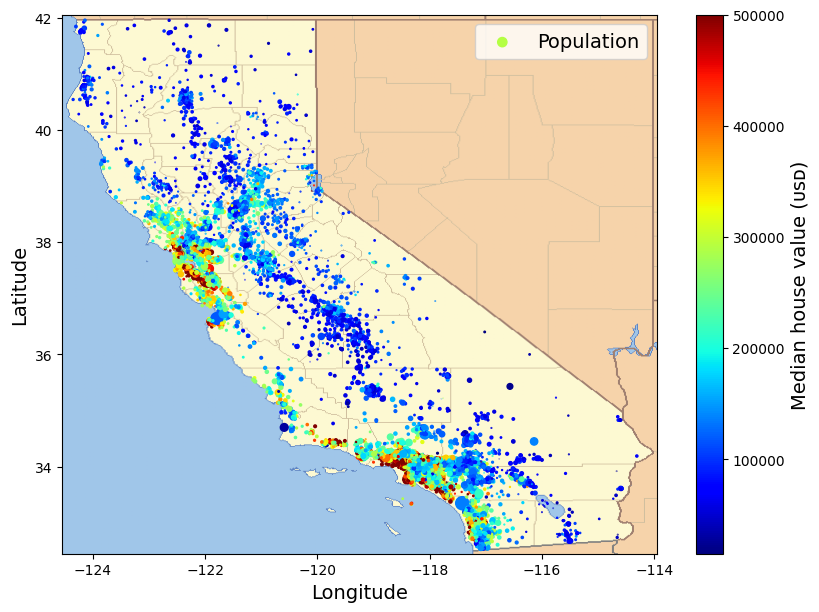

In [72]:
filename = "california.png"
if not (IMAGES_PATH / filename).is_file():
    homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
    url = homl3_root + "images/end_to_end_project/" + filename
    print("Downloading", filename)
    urllib.request.urlretrieve(url, IMAGES_PATH / filename)

housing_renamed = df_train.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed.plot(
             kind="scatter", x="Longitude", y="Latitude",
             s=housing_renamed["Population"] / 400, label="Population",
             c="Median house value (ᴜsᴅ)", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

california_img = plt.imread(IMAGES_PATH / filename)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)
plt.show()

### Looking for Correlations

In [73]:
corr_matrix = df_train_copy.corr()
corr_matrix.median_house_value.sort_values(ascending=False)

<ipython-input-73-fa24ded32470>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_train_copy.corr()


median_house_value    1.000000
median_income         0.687013
total_rooms           0.134060
housing_median_age    0.104714
households            0.065798
total_bedrooms        0.049993
population           -0.025820
longitude            -0.043603
latitude             -0.146324
Name: median_house_value, dtype: float64

Note that correlation is linear and may miss out on non linear relationships

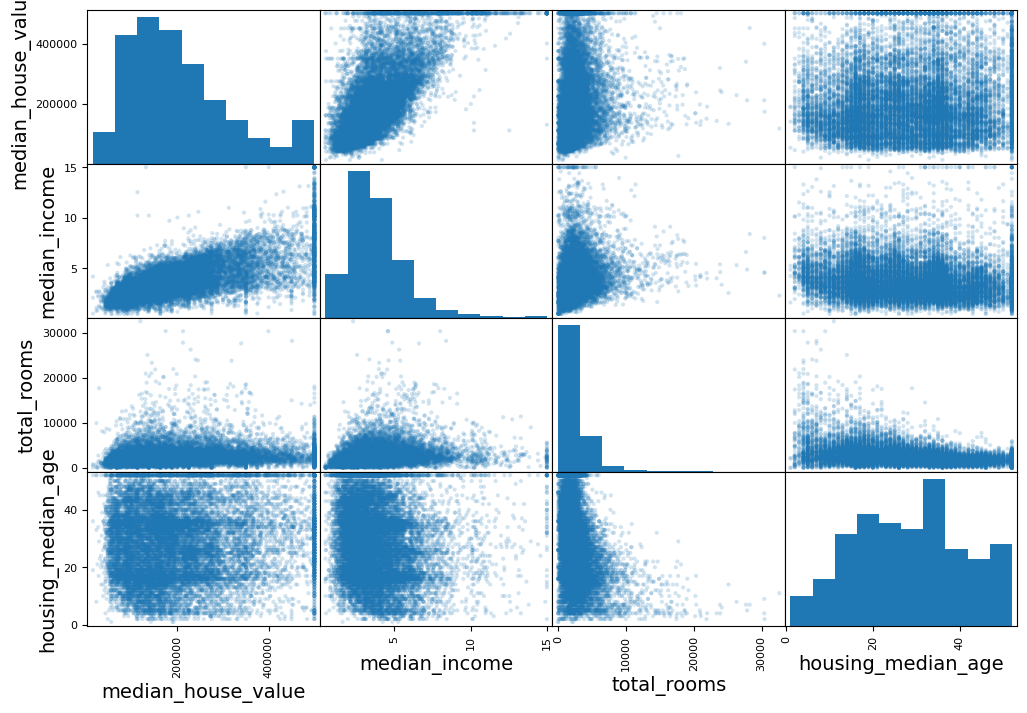

In [74]:
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]

scatter_matrix(df_train_copy[attributes], figsize=(12, 8), alpha=0.2)
plt.show()

Things to notice below:
- strong positive corelation
- Price cap of \$500,000 is seen
- a horizontal line around \$450,000, another around \$350,000, perhaps one around \$280,000, and a few more below that. You may want to try removing the corresponding districts to prevent your algorithms from learning to reproduce these data quirks


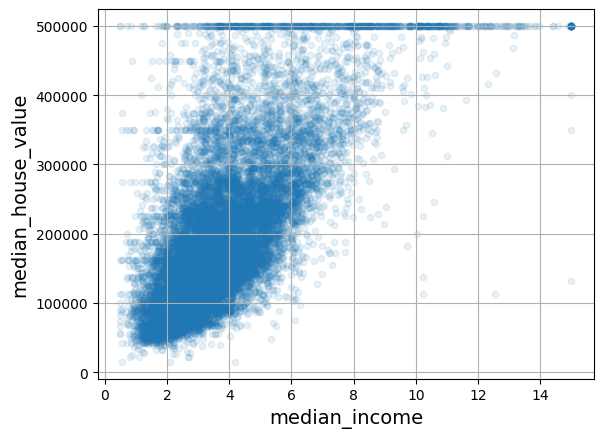

In [75]:
df_train_copy.plot(kind="scatter", x="median_income", y="median_house_value",
                   alpha=0.1, grid=True)
plt.show()

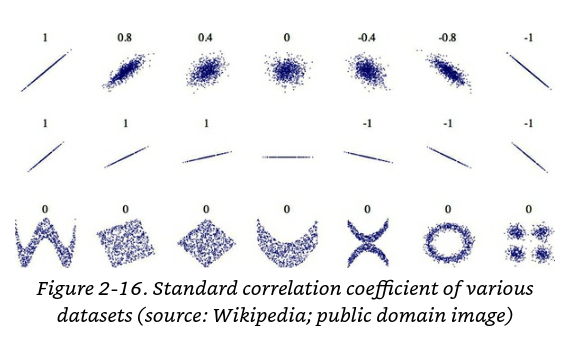

### Experimenting with Attribute Combinations

In [76]:
df_train_copy["rooms_per_house"] = df_train_copy["total_rooms"] / df_train_copy["households"]
df_train_copy["bedrooms_ratio"] = df_train_copy["total_bedrooms"] / df_train_copy["total_rooms"]
df_train_copy["people_per_house"] = df_train_copy["population"] / df_train_copy["households"]

In [77]:
corr_matrix = df_train_copy.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

<ipython-input-77-6e32e5e43ac4>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_train_copy.corr()


median_house_value    1.000000
median_income         0.687013
rooms_per_house       0.146940
total_rooms           0.134060
housing_median_age    0.104714
households            0.065798
total_bedrooms        0.049993
people_per_house     -0.021577
population           -0.025820
longitude            -0.043603
latitude             -0.146324
bedrooms_ratio       -0.254817
Name: median_house_value, dtype: float64

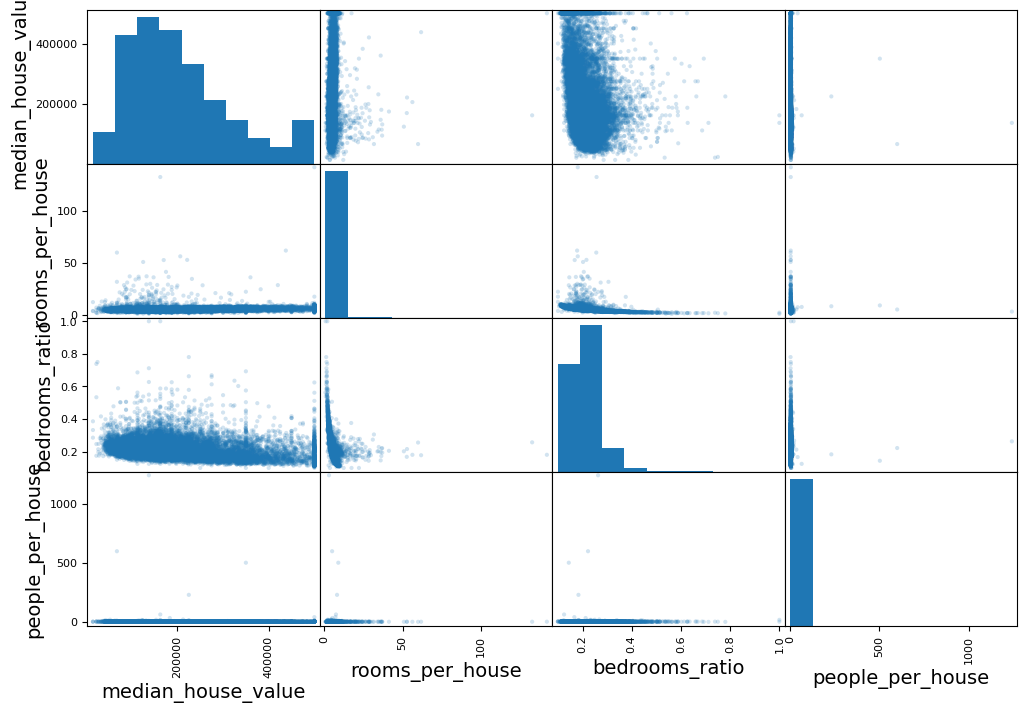

In [78]:
attributes = ["median_house_value", "rooms_per_house", "bedrooms_ratio", "people_per_house"]

scatter_matrix(df_train_copy[attributes], figsize=(12, 8), alpha=0.2)
plt.show()

## Prepare the Data for Machine Learning Algorithms

Let's revert to the original training set and separate the target (note that `strat_train_set.drop()` creates a copy of `strat_train_set` without the column, it doesn't actually modify `strat_train_set` itself, unless you pass `inplace=True`):

In [79]:
X_train = df_train.drop("median_house_value", axis=1)
y_train = df_train["median_house_value"].copy()

### Data Cleaning

In the book 3 options are listed to handle the NaN values:

```python
housing.dropna(subset=["total_bedrooms"], inplace=True)    # option 1 - remove districts

housing.drop("total_bedrooms", axis=1)       # option 2 - remove attribute

median = housing["total_bedrooms"].median()  # option 3 - impute median values
housing["total_bedrooms"].fillna(median, inplace=True)
```

For each option, we'll create a copy of `housing` and work on that copy to avoid breaking `housing`. We'll also show the output of each option, but filtering on the rows that originally contained a NaN value.

In [80]:
# Check null columns
null_rows_idx = X_train.isnull().any(axis=1)
X_train.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
9529,-118.31,33.94,40.0,1550.0,NaN,798.0,270.0,3.7750,<1H OCEAN,3
16519,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN,4
19782,-119.75,34.45,6.0,2864.0,NaN,1404.0,603.0,5.5073,NEAR OCEAN,4
1343,-120.32,37.29,38.0,576.0,NaN,478.0,112.0,2.3382,INLAND,2
9827,-121.85,36.61,38.0,238.0,NaN,191.0,67.0,1.3897,<1H OCEAN,1


In [81]:
X_train_option1 = X_train.copy()
X_train_option1.dropna(subset=["total_bedrooms"], inplace=True)
X_train_option1.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat


In [82]:
X_train_option2 = X_train.copy()
X_train_option2.drop("total_bedrooms", axis=1, inplace=True)
X_train_option2.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity,income_cat
9529,-118.31,33.94,40.0,1550.0,798.0,270.0,3.7750,<1H OCEAN,3
16519,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN,4
19782,-119.75,34.45,6.0,2864.0,1404.0,603.0,5.5073,NEAR OCEAN,4
1343,-120.32,37.29,38.0,576.0,478.0,112.0,2.3382,INLAND,2
9827,-121.85,36.61,38.0,238.0,191.0,67.0,1.3897,<1H OCEAN,1


In [83]:
X_train_option3 = X_train.copy()

median = df_train["total_bedrooms"].median()
X_train_option3["total_bedrooms"].fillna(median, inplace=True)

X_train_option3.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
9529,-118.31,33.94,40.0,1550.0,437.0,798.0,270.0,3.7750,<1H OCEAN,3
16519,-117.86,34.01,16.0,4632.0,437.0,3038.0,727.0,5.1762,<1H OCEAN,4
19782,-119.75,34.45,6.0,2864.0,437.0,1404.0,603.0,5.5073,NEAR OCEAN,4
1343,-120.32,37.29,38.0,576.0,437.0,478.0,112.0,2.3382,INLAND,2
9827,-121.85,36.61,38.0,238.0,437.0,191.0,67.0,1.3897,<1H OCEAN,1


In [84]:
# We can carry out option 3 using the SimpleImputer class
# We can also use mean, most_frequenct, or constant
imputer = SimpleImputer(strategy="median")

Separating out the numerical attributes to use the `"median"` strategy (as it cannot be calculated on text attributes like `ocean_proximity`):

In [85]:
X_train_num = X_train.select_dtypes(include=[np.number])
imputer.fit(X_train_num)

imputer.statistics_

array([-118.49  ,   34.25  ,   29.    , 2129.    ,  437.    , 1169.    ,
        411.    ,    3.5246])

Check that this is the same as manually computing the median of each attribute:

In [86]:
X_train_num.median().values

array([-118.49  ,   34.25  ,   29.    , 2129.    ,  437.    , 1169.    ,
        411.    ,    3.5246])

There are also more powerful imputers available in the sklearn.impute package (both for numerical features only):
* KNNImputer replaces each missing value with the mean of the k-nearest neighbors’ values for that feature. The distance is based on all the available features.

* IterativeImputer trains a regression model per feature to predict the missing values based on all the other available features. It then trains the model again on the updated data, and repeats the process several times, improving the models and the replacement values at each iteration.

Transform the training set:

In [87]:
X = imputer.transform(X_train_num)

In [88]:
imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [89]:
X_train_num = pd.DataFrame(X, columns=X_train_num.columns, index=X_train_num.index)

In [90]:
X_train_num.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
9529,-118.31,33.94,40.0,1550.0,437.0,798.0,270.0,3.7750
16519,-117.86,34.01,16.0,4632.0,437.0,3038.0,727.0,5.1762
19782,-119.75,34.45,6.0,2864.0,437.0,1404.0,603.0,5.5073
1343,-120.32,37.29,38.0,576.0,437.0,478.0,112.0,2.3382
9827,-121.85,36.61,38.0,238.0,437.0,191.0,67.0,1.3897


In [91]:
imputer.strategy

'median'

Now let's drop some outliers:

In [92]:
isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)
outlier_pred

array([-1,  1, -1, ...,  1,  1,  1])

If you wanted to drop outliers, you would run the following code:

In [93]:
print(f"len before: {len(X_train)}")

X_train = X_train.iloc[outlier_pred == 1]
y_train = y_train.iloc[outlier_pred == 1]

print(f"len after: {len(X_train)}")

len before: 16512
len after: 14431


In [94]:
X_train

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
8267,-117.03,32.69,10.0,901.0,163.0,698.0,167.0,4.6648,NEAR OCEAN,4
14265,-121.82,37.25,25.0,4021.0,634.0,2178.0,650.0,5.1663,<1H OCEAN,4
9389,-118.41,34.29,32.0,1591.0,320.0,1818.0,306.0,4.2969,<1H OCEAN,3
6113,-119.95,38.94,24.0,2180.0,517.0,755.0,223.0,2.5875,INLAND,2
6061,-122.66,38.47,23.0,2246.0,437.0,1035.0,386.0,3.7617,<1H OCEAN,3
...,...,...,...,...,...,...,...,...,...,...
11284,-122.37,37.94,49.0,969.0,229.0,599.0,195.0,1.3167,NEAR BAY,1
11964,-118.38,33.89,35.0,1778.0,330.0,732.0,312.0,6.5745,<1H OCEAN,5
5390,-119.33,36.28,16.0,2624.0,527.0,1077.0,520.0,2.1250,INLAND,2
860,-117.19,34.08,22.0,2467.0,555.0,1567.0,494.0,2.6536,INLAND,2


### Handling Text and Categorical Attributes

Now let's preprocess the categorical input feature, `ocean_proximity`:

In [95]:
X_train.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'income_cat'],
      dtype='object')

In [96]:
X_train_cat = X_train[["ocean_proximity"]]
X_train_cat.head()

,ocean_proximity
8267,NEAR OCEAN
14265,<1H OCEAN
9389,<1H OCEAN
6113,INLAND
6061,<1H OCEAN


Ordinal Encoding:

In [98]:
ordinal_encoder = OrdinalEncoder()
X_train_cat_encoded = ordinal_encoder.fit_transform(X_train_cat)

In [107]:
X_train[["ocean_proximity"]][:8]

8267     NEAR OCEAN
14265     <1H OCEAN
9389      <1H OCEAN
6113         INLAND
6061      <1H OCEAN
16030     <1H OCEAN
8364     NEAR OCEAN
17529      NEAR BAY
Name: ocean_proximity, dtype: object

In [104]:
X_train_cat_encoded[:8].flatten()

array([4., 0., 0., 1., 0., 0., 4., 3.])

In [100]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [110]:
ocean_prox = X_train["ocean_proximity"][:10]
encoded = X_train_cat_encoded[:10].flatten()
concated_data = zip(ocean_prox, encoded)
encoded_result = pd.DataFrame(concated_data, columns=('Ocean Proximity', 'Encoded Value'))
encoded_result.head(10)

,Ocean Proximity,Encoded Value
0,NEAR OCEAN,4.0
1,<1H OCEAN,0.0
2,<1H OCEAN,0.0
3,INLAND,1.0
4,<1H OCEAN,0.0
5,<1H OCEAN,0.0
6,NEAR OCEAN,4.0
7,NEAR BAY,3.0
8,INLAND,1.0
9,INLAND,1.0


One Hot Encoding:

In [113]:
cat_encoder = OneHotEncoder()
X_train_cat_1hot = cat_encoder.fit_transform(X_train_cat)
X_train_cat_1hot

<14431x5 sparse matrix of type '<class 'numpy.float64'>'
	with 14431 stored elements in Compressed Sparse Row format>

By default, the `OneHotEncoder` class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:

In [114]:
X_train_cat_1hot.toarray()

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

Alternatively, you can set `sparse=False` when creating the `OneHotEncoder`:

In [115]:
cat_encoder = OneHotEncoder(sparse=False)
X_train_cat_1hot = cat_encoder.fit_transform(X_train_cat)
X_train_cat_1hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [116]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [119]:
df_test_dummies = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test_dummies)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,1,0
1,0,1


In [120]:
cat_encoder.transform(df_test_dummies)

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [121]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,1,0
1,0,1


In [122]:
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown)

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [123]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [125]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [128]:
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown),
                         columns=cat_encoder.get_feature_names_out(),
                         index=df_test_unknown.index)

df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0


### Feature Scaling

In [130]:
# Min max is not appropriate if there are outliers as it squishes the majority data
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_num_min_max_scaled = min_max_scaler.fit_transform(X_train_num)

In [131]:
# Standard Scaler
std_scaler = StandardScaler()
X_train_num_std_scaled = std_scaler.fit_transform(X_train_num)

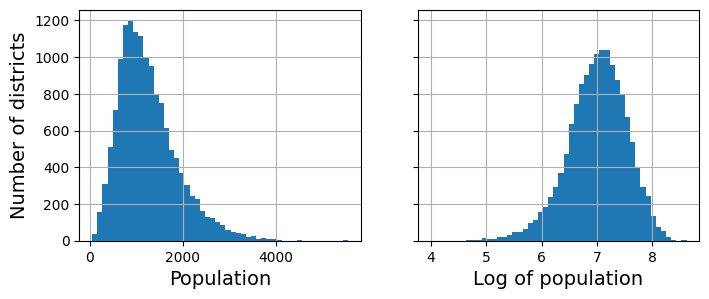

In [133]:
# Below converts the data to a gaussian which is more appropriate to feed into an ML Model
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
X_train["population"].hist(ax=axs[0], bins=50)
X_train["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")

plt.show()

What if we replace each value with its percentile?

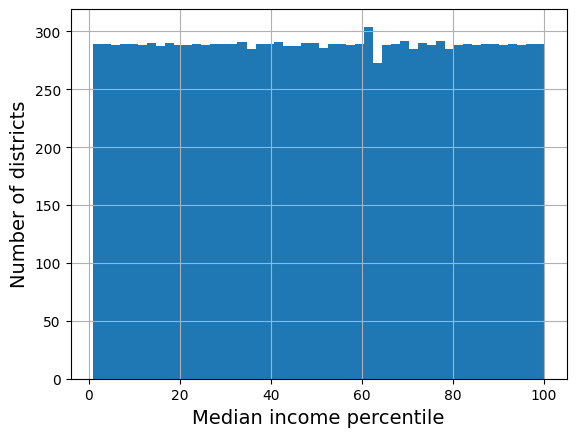

In [134]:
# Uniform distribution from bucketising percentiles
percentiles = [np.percentile(X_train["median_income"], p)
               for p in range(1, 100)]
flattened_median_income = pd.cut(X_train["median_income"],
                                 bins=[-np.inf] + percentiles + [np.inf],
                                 labels=range(1, 100 + 1))
flattened_median_income.hist(bins=50)
plt.xlabel("Median income percentile")
plt.ylabel("Number of districts")
plt.show()
# Note: incomes below the 1st percentile are labeled 1, and incomes above the
# 99th percentile are labeled 100. This is why the distribution below ranges
# from 1 to 100 (not 0 to 100).

In [139]:
age_simil_35 = rbf_kernel(X_train[["housing_median_age"]], [[35]], gamma=0.1)

In [146]:
# Check RBF visually
ages = np.linspace(X_train.housing_median_age.min(),
                  X_train.housing_median_age.max(),
                  500).reshape(-1, 1)

gamma1 = 0.1
gamma2 = 0.03

rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

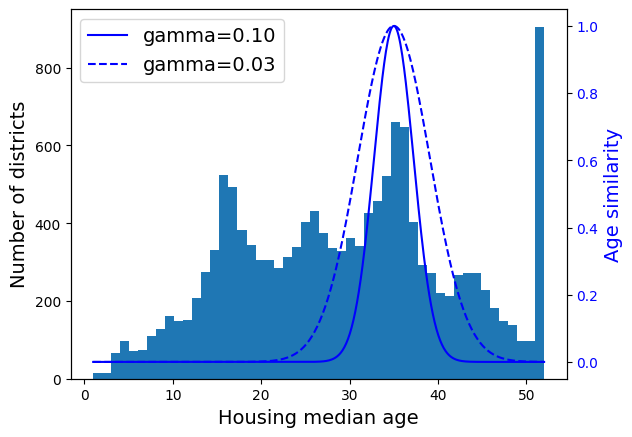

In [147]:
fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(X_train["housing_median_age"], bins=50)

ax2 = ax1.twinx()
color = "blue"
ax2.plot(ages, rbf1, color=color, label="gamma=0.10")
ax2.plot(ages, rbf2, color=color, label="gamma=0.03", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")
plt.show()

In [153]:
# We might need to standard scale the labels too. Sklearn provides inverse scaling capabilities
target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(y_train.to_frame())

model = LinearRegression()
model.fit(X_train[["median_income"]], scaled_labels)
some_new_data = X_train[["median_income"]].iloc[:5] # pretend this is new data

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)
predictions

array([[244993.13065534],
       [267891.52344886],
       [228194.88796593],
       [150144.01530143],
       [203757.75970453]])

In [157]:
# Transformed target regressor can do this in one go
model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())

model.fit(X_train[["median_income"]], y_train)
predicitons = model.predict(some_new_data)
predicitons

array([244993.13065534, 267891.52344886, 228194.88796593, 150144.01530143,
       203757.75970453])

### Custom Transformers

Custom transformers are required for cleanup operations, or cobining specific attributes

To create simple transformers:

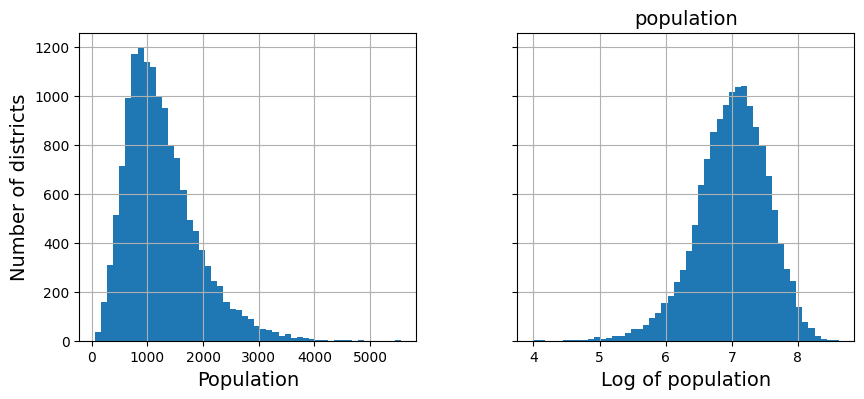

In [172]:
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(X_train[["population"]])

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
X_train["population"].hist(ax=axs[0], bins=50)
log_pop.hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")

plt.show()

In [177]:
X_train.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'income_cat'],
      dtype='object')

In [174]:
rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[35.]], gamma=0.1))
age_siml_35 = rbf_transformer.transform(X_train[["housing_median_age"]])
age_siml_35


array([[7.18778174e-28],
       [4.53999298e-05],
       [4.06569660e-01],
       ...,
       [2.09879105e-16],
       [4.57533877e-08],
       [4.57533877e-08]])

In [182]:
"""
Here we pass in Sanfrancisco coords to measure the similarity as RBF
"Since the value of the RBF kernel decreases with distance and ranges
between zero (in the limit) and one (when x = x'), it has a ready interpretation as a similarity measure."
See https://en.wikipedia.org/wiki/Radial_basis_function_kernel
"""
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel,
                                     kw_args=dict(Y=[sf_coords], gamma=0.1))

sf_simil = sf_transformer.transform(X_train[["latitude", "longitude"]])


geo_lat = X_train["latitude"][:10]
geo_lon = X_train["longitude"][:10]
sf_simil = sf_simil[:10].flatten()
concated_data = zip(geo_lat, geo_lon, sf_simil)
sf_simil_df = pd.DataFrame(concated_data, columns=('latitude', 'longitude', 'sf_simil'))
sf_simil_df.head(10)

,latitude,longitude,sf_simil
0,32.69,-117.03,0.004169
1,37.25,-121.82,0.939543
2,34.29,-118.41,0.059938
3,38.94,-119.95,0.476682
4,38.47,-122.66,0.946896
5,34.00,-118.11,0.037855
6,33.80,-118.19,0.034707
7,37.75,-122.13,0.992129
8,38.56,-121.51,0.867068
9,37.93,-121.66,0.943031


Custom transformers are aso useful to combine features.
e.g. computing the ratio between the input features of 0 and 1:

In [197]:
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

In [ ]:
class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):  # no *args or **kwargs!
        self.with_mean = with_mean

    def fit(self, X, y=None):  # y is required even though we don't use it
        X = check_array(X)  # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

Custom transformer can and often does use other estimators in its implementation.

E.g. The following code demonstrates custom transformer that uses a KMeans clusterer in the fit() method to identify the main clusters in the training data, and then uses rbf_kernel() in the transform() method to measure how similar each sample is to each cluster center

In [202]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
  def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
    self.n_clusters = n_clusters
    self.gamma = gamma
    self.random_state = random_state

  def fit(self, X, y=None, sample_weight=None):
    self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
    self.kmeans_.fit(X, sample_weight=sample_weight)
    return self # Always return self!

  def transform(self, X):
    return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

  def get_feature_names_out(self, names=None):
    return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [203]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(X_train[["latitude", "longitude"]],
                                           sample_weight=y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [206]:
pd.DataFrame(similarities[:3].round(2))

,0,1,2,3,4,5,6,7,8,9
0,0.00,0.03,0.0,0.95,0.0,0.00,0.00,0.00,0.14,0.0
1,0.51,0.00,0.0,0.00,0.0,0.06,0.00,0.98,0.00,0.4
2,0.00,0.94,0.0,0.02,0.0,0.00,0.12,0.00,0.57,0.0


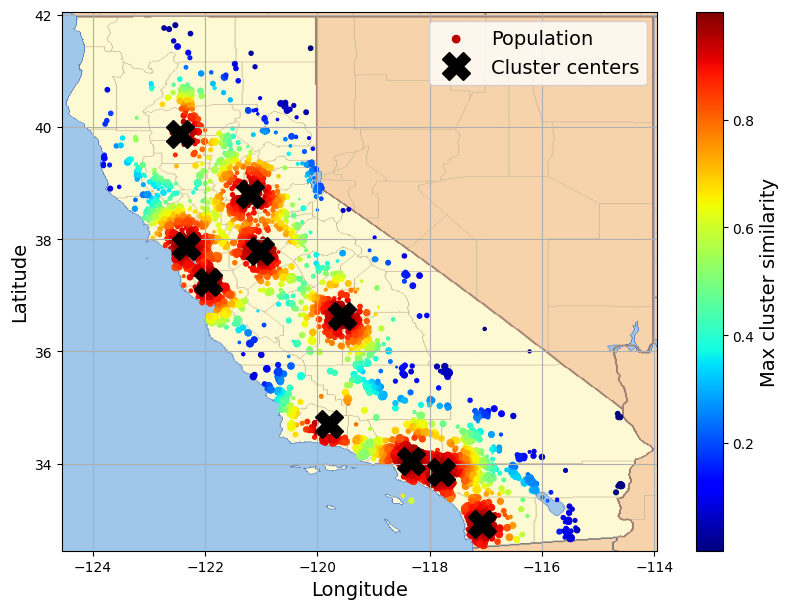

In [209]:
X_train_renamed = X_train.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})

X_train_renamed["Max cluster similarity"] = similarities.max(axis=1)


X_train_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=X_train_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")


california_img = plt.imread(IMAGES_PATH / filename)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)
plt.show()

### Transformation Pipelines

Now let's build a pipeline to preprocess the numerical attributes:

In [ ]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

In [ ]:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

In [ ]:
from sklearn import set_config

set_config(display='diagram')

num_pipeline

In [ ]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

In [ ]:
def monkey_patch_get_signature_names_out():
    """Monkey patch some classes which did not handle get_feature_names_out()
       correctly in Scikit-Learn 1.0.*."""
    from inspect import Signature, signature, Parameter
    import pandas as pd
    from sklearn.impute import SimpleImputer
    from sklearn.pipeline import make_pipeline, Pipeline
    from sklearn.preprocessing import FunctionTransformer, StandardScaler

    default_get_feature_names_out = StandardScaler.get_feature_names_out

    if not hasattr(SimpleImputer, "get_feature_names_out"):
      print("Monkey-patching SimpleImputer.get_feature_names_out()")
      SimpleImputer.get_feature_names_out = default_get_feature_names_out

    if not hasattr(FunctionTransformer, "get_feature_names_out"):
        print("Monkey-patching FunctionTransformer.get_feature_names_out()")
        orig_init = FunctionTransformer.__init__
        orig_sig = signature(orig_init)

        def __init__(*args, feature_names_out=None, **kwargs):
            orig_sig.bind(*args, **kwargs)
            orig_init(*args, **kwargs)
            args[0].feature_names_out = feature_names_out

        __init__.__signature__ = Signature(
            list(signature(orig_init).parameters.values()) + [
                Parameter("feature_names_out", Parameter.KEYWORD_ONLY)])

        def get_feature_names_out(self, names=None):
            if callable(self.feature_names_out):
                return self.feature_names_out(self, names)
            assert self.feature_names_out == "one-to-one"
            return default_get_feature_names_out(self, names)

        FunctionTransformer.__init__ = __init__
        FunctionTransformer.get_feature_names_out = get_feature_names_out

monkey_patch_get_signature_names_out()

In [ ]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index)

In [ ]:
df_housing_num_prepared.head(2)  # extra code

In [ ]:
num_pipeline.steps

In [ ]:
num_pipeline[1]

In [ ]:
num_pipeline[:-1]

In [ ]:
num_pipeline.named_steps["simpleimputer"]

In [ ]:
num_pipeline.set_params(simpleimputer__strategy="median")

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

In [ ]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

In [ ]:
housing_prepared = preprocessing.fit_transform(housing)

In [ ]:
# extra code – shows that we can get a DataFrame out if we want
housing_prepared_fr = pd.DataFrame(
    housing_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=housing.index)
housing_prepared_fr.head(2)

In [ ]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

In [ ]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

In [ ]:
preprocessing.get_feature_names_out()

# Select and Train a Model

## Training and Evaluating on the Training Set

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Let's try the full preprocessing pipeline on a few training instances:

In [ ]:
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)  # -2 = rounded to the nearest hundred

Compare against the actual values:

In [ ]:
housing_labels.iloc[:5].values

In [ ]:
# extra code – computes the error ratios discussed in the book
error_ratios = housing_predictions[:5].round(-2) / housing_labels.iloc[:5].values - 1
print(", ".join([f"{100 * ratio:.1f}%" for ratio in error_ratios]))

In [ ]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared=False)
lin_rmse

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

In [ ]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared=False)
tree_rmse

## Better Evaluation Using Cross-Validation

In [ ]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)

In [ ]:
pd.Series(tree_rmses).describe()

In [ ]:
# extra code – computes the error stats for the linear model
lin_rmses = -cross_val_score(lin_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

**Warning:** the following cell may take a few minutes to run:

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                                scoring="neg_root_mean_squared_error", cv=10)

In [ ]:
pd.Series(forest_rmses).describe()

Let's compare this RMSE measured using cross-validation (the "validation error") with the RMSE measured on the training set (the "training error"):

In [ ]:
forest_reg.fit(housing, housing_labels)
housing_predictions = forest_reg.predict(housing)
forest_rmse = mean_squared_error(housing_labels, housing_predictions,
                                 squared=False)
forest_rmse

The training error is much lower than the validation error, which usually means that the model has overfit the training set. Another possible explanation may be that there's a mismatch between the training data and the validation data, but it's not the case here, since both came from the same dataset that we shuffled and split in two parts.

# Fine-Tune Your Model

## Grid Search

**Warning:** the following cell may take a few minutes to run:

In [ ]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

You can get the full list of hyperparameters available for tuning by looking at `full_pipeline.get_params().keys()`:

In [ ]:
# extra code – shows part of the output of get_params().keys()
print(str(full_pipeline.get_params().keys())[:1000] + "...")

The best hyperparameter combination found:

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_estimator_

Let's look at the score of each hyperparameter combination tested during the grid search:

In [ ]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

# extra code – these few lines of code just make the DataFrame look nicer
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

## Randomized Search

In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

Try 30 (`n_iter` × `cv`) random combinations of hyperparameters:

**Warning:** the following cell may take a few minutes to run:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

In [ ]:
# extra code – displays the random search results
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

**Bonus section: how to choose the sampling distribution for a hyperparameter**

* `scipy.stats.randint(a, b+1)`: for hyperparameters with _discrete_ values that range from a to b, and all values in that range seem equally likely.
* `scipy.stats.uniform(a, b)`: this is very similar, but for _continuous_ hyperparameters.
* `scipy.stats.geom(1 / scale)`: for discrete values, when you want to sample roughly in a given scale. E.g., with scale=1000 most samples will be in this ballpark, but ~10% of all samples will be <100 and ~10% will be >2300.
* `scipy.stats.expon(scale)`: this is the continuous equivalent of `geom`. Just set `scale` to the most likely value.
* `scipy.stats.loguniform(a, b)`: when you have almost no idea what the optimal hyperparameter value's scale is. If you set a=0.01 and b=100, then you're just as likely to sample a value between 0.01 and 0.1 as a value between 10 and 100.


Here are plots of the probability mass functions (for discrete variables), and probability density functions (for continuous variables) for `randint()`, `uniform()`, `geom()` and `expon()`:

In [ ]:
# extra code – plots a few distributions you can use in randomized search

from scipy.stats import randint, uniform, geom, expon

xs1 = np.arange(0, 7 + 1)
randint_distrib = randint(0, 7 + 1).pmf(xs1)

xs2 = np.linspace(0, 7, 500)
uniform_distrib = uniform(0, 7).pdf(xs2)

xs3 = np.arange(0, 7 + 1)
geom_distrib = geom(0.5).pmf(xs3)

xs4 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs4)

plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.bar(xs1, randint_distrib, label="scipy.randint(0, 7 + 1)")
plt.ylabel("Probability")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 2)
plt.fill_between(xs2, uniform_distrib, label="scipy.uniform(0, 7)")
plt.ylabel("PDF")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 3)
plt.bar(xs3, geom_distrib, label="scipy.geom(0.5)")
plt.xlabel("Hyperparameter value")
plt.ylabel("Probability")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.subplot(2, 2, 4)
plt.fill_between(xs4, expon_distrib, label="scipy.expon(scale=1)")
plt.xlabel("Hyperparameter value")
plt.ylabel("PDF")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.show()

Here are the PDF for `expon()` and `loguniform()` (left column), as well as the PDF of log(X) (right column). The right column shows the distribution of hyperparameter _scales_. You can see that `expon()` favors hyperparameters with roughly the desired scale, with a longer tail towards the smaller scales. But `loguniform()` does not favor any scale, they are all equally likely:

In [ ]:
# extra code – shows the difference between expon and loguniform

from scipy.stats import loguniform

xs1 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs1)

log_xs2 = np.linspace(-5, 3, 500)
log_expon_distrib = np.exp(log_xs2 - np.exp(log_xs2))

xs3 = np.linspace(0.001, 1000, 500)
loguniform_distrib = loguniform(0.001, 1000).pdf(xs3)

log_xs4 = np.linspace(np.log(0.001), np.log(1000), 500)
log_loguniform_distrib = uniform(np.log(0.001), np.log(1000)).pdf(log_xs4)

plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.fill_between(xs1, expon_distrib,
                 label="scipy.expon(scale=1)")
plt.ylabel("PDF")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.subplot(2, 2, 2)
plt.fill_between(log_xs2, log_expon_distrib,
                 label="log(X) with X ~ expon")
plt.legend()
plt.axis([-5, 3, 0, 1])

plt.subplot(2, 2, 3)
plt.fill_between(xs3, loguniform_distrib,
                 label="scipy.loguniform(0.001, 1000)")
plt.xlabel("Hyperparameter value")
plt.ylabel("PDF")
plt.legend()
plt.axis([0.001, 1000, 0, 0.005])

plt.subplot(2, 2, 4)
plt.fill_between(log_xs4, log_loguniform_distrib,
                 label="log(X) with X ~ loguniform")
plt.xlabel("Log of hyperparameter value")
plt.legend()
plt.axis([-8, 1, 0, 0.2])

plt.show()

## Analyze the Best Models and Their Errors

In [ ]:
final_model = rnd_search.best_estimator_  # includes preprocessing
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

In [ ]:
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

## Evaluate Your System on the Test Set

In [ ]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

We can compute a 95% confidence interval for the test RMSE:

In [ ]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

We could compute the interval manually like this:

In [ ]:
# extra code – shows how to compute a confidence interval for the RMSE
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

Alternatively, we could use a z-score rather than a t-score. Since the test set is not too small, it won't make a big difference:

In [ ]:
# extra code – computes a confidence interval again using a z-score
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

## Model persistence using joblib

Save the final model:

In [ ]:
import joblib

joblib.dump(final_model, "my_california_housing_model.pkl")

Now you can deploy this model to production. For example, the following code could be a script that would run in production:

In [ ]:
import joblib

# extra code – excluded for conciseness
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

#class ClusterSimilarity(BaseEstimator, TransformerMixin):
#    [...]

final_model_reloaded = joblib.load("my_california_housing_model.pkl")

new_data = housing.iloc[:5]  # pretend these are new districts
predictions = final_model_reloaded.predict(new_data)

In [ ]:
predictions

You could use pickle instead, but joblib is more efficient.

# Exercise solutions

## 1.

Exercise: _Try a Support Vector Machine regressor (`sklearn.svm.SVR`) with various hyperparameters, such as `kernel="linear"` (with various values for the `C` hyperparameter) or `kernel="rbf"` (with various values for the `C` and `gamma` hyperparameters). Note that SVMs don't scale well to large datasets, so you should probably train your model on just the first 5,000 instances of the training set and use only 3-fold cross-validation, or else it will take hours. Don't worry about what the hyperparameters mean for now (see the SVM notebook if you're interested). How does the best `SVR` predictor perform?_

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

param_grid = [
        {'svr__kernel': ['linear'], 'svr__C': [10., 30., 100., 300., 1000.,
                                               3000., 10000., 30000.0]},
        {'svr__kernel': ['rbf'], 'svr__C': [1.0, 3.0, 10., 30., 100., 300.,
                                            1000.0],
         'svr__gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svr_pipeline = Pipeline([("preprocessing", preprocessing), ("svr", SVR())])
grid_search = GridSearchCV(svr_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000])

The best model achieves the following score (evaluated using 3-fold cross validation):

In [ ]:
svr_grid_search_rmse = -grid_search.best_score_
svr_grid_search_rmse

That's much worse than the `RandomForestRegressor` (but to be fair, we trained the model on much less data). Let's check the best hyperparameters found:

In [ ]:
grid_search.best_params_

The linear kernel seems better than the RBF kernel. Notice that the value of `C` is the maximum tested value. When this happens you definitely want to launch the grid search again with higher values for `C` (removing the smallest values), because it is likely that higher values of `C` will be better.

## 2.

Exercise: _Try replacing the `GridSearchCV` with a `RandomizedSearchCV`._

**Warning:** the following cell will take several minutes to run. You can specify `verbose=2` when creating the `RandomizedSearchCV` if you want to see the training details.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, loguniform

# see https://docs.scipy.org/doc/scipy/reference/stats.html
# for `expon()` and `loguniform()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'svr__kernel': ['linear', 'rbf'],
        'svr__C': loguniform(20, 200_000),
        'svr__gamma': expon(scale=1.0),
    }

rnd_search = RandomizedSearchCV(svr_pipeline,
                                param_distributions=param_distribs,
                                n_iter=50, cv=3,
                                scoring='neg_root_mean_squared_error',
                                random_state=42)
rnd_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000])

The best model achieves the following score (evaluated using 3-fold cross validation):

In [ ]:
svr_rnd_search_rmse = -rnd_search.best_score_
svr_rnd_search_rmse

Now that's really much better, but still far from the `RandomForestRegressor`'s performance. Let's check the best hyperparameters found:

In [ ]:
rnd_search.best_params_

This time the search found a good set of hyperparameters for the RBF kernel. Randomized search tends to find better hyperparameters than grid search in the same amount of time.

Note that we used the `expon()` distribution for `gamma`, with a scale of 1, so `RandomSearch` mostly searched for values roughly of that scale: about 80% of the samples were between 0.1 and 2.3 (roughly 10% were smaller and 10% were larger):

In [ ]:
np.random.seed(42)

s = expon(scale=1).rvs(100_000)  # get 100,000 samples
((s > 0.105) & (s < 2.29)).sum() / 100_000

We used the `loguniform()` distribution for `C`, meaning we did not have a clue what the optimal scale of `C` was before running the random search. It explored the range from 20 to 200 just as much as the range from 2,000 to 20,000 or from 20,000 to 200,000.

## 3.

Exercise: _Try adding a `SelectFromModel` transformer in the preparation pipeline to select only the most important attributes._

Let's create a new pipeline that runs the previously defined preparation pipeline, and adds a `SelectFromModel` transformer based on a `RandomForestRegressor` before the final regressor:

In [ ]:
from sklearn.feature_selection import SelectFromModel

selector_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('selector', SelectFromModel(RandomForestRegressor(random_state=42),
                                 threshold=0.005)),  # min feature importance
    ('svr', SVR(C=rnd_search.best_params_["svr__C"],
                gamma=rnd_search.best_params_["svr__gamma"],
                kernel=rnd_search.best_params_["svr__kernel"])),
])

In [ ]:
selector_rmses = -cross_val_score(selector_pipeline,
                                  housing.iloc[:5000],
                                  housing_labels.iloc[:5000],
                                  scoring="neg_root_mean_squared_error",
                                  cv=3)
pd.Series(selector_rmses).describe()

Oh well, feature selection does not seem to help. But maybe that's just because the threshold we used was not optimal. Perhaps try tuning it using random search or grid search?

## 4.

Exercise: _Try creating a custom transformer that trains a k-Nearest Neighbors regressor (`sklearn.neighbors.KNeighborsRegressor`) in its `fit()` method, and outputs the model's predictions in its `transform()` method. Then add this feature to the preprocessing pipeline, using latitude and longitude as the inputs to this transformer. This will add a feature in the model that corresponds to the housing median price of the nearest districts._

Rather than restrict ourselves to k-Nearest Neighbors regressors, let's create a transformer that accepts any regressor. For this, we can extend the `MetaEstimatorMixin` and have a required `estimator` argument in the constructor. The `fit()` method must work on a clone of this estimator, and it must also save `feature_names_in_`. The `MetaEstimatorMixin` will ensure that `estimator` is listed as a required parameters, and it will update `get_params()` and `set_params()` to make the estimator's hyperparameters available for tuning. Lastly, we create a `get_feature_names_out()` method: the output column name is the ...

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import MetaEstimatorMixin, clone

class FeatureFromRegressor(MetaEstimatorMixin, BaseEstimator, TransformerMixin):
    def __init__(self, estimator):
        self.estimator = estimator

    def fit(self, X, y=None):
        estimator_ = clone(self.estimator)
        estimator_.fit(X, y)
        self.estimator_ = estimator_
        self.n_features_in_ = self.estimator_.n_features_in_
        if hasattr(self.estimator, "feature_names_in_"):
            self.feature_names_in_ = self.estimator.feature_names_in_
        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)
        predictions = self.estimator_.predict(X)
        if predictions.ndim == 1:
            predictions = predictions.reshape(-1, 1)
        return predictions

    def get_feature_names_out(self, names=None):
        check_is_fitted(self)
        n_outputs = getattr(self.estimator_, "n_outputs_", 1)
        estimator_class_name = self.estimator_.__class__.__name__
        estimator_short_name = estimator_class_name.lower().replace("_", "")
        return [f"{estimator_short_name}_prediction_{i}"
                for i in range(n_outputs)]

Let's ensure it complies to Scikit-Learn's API:

In [ ]:
from sklearn.utils.estimator_checks import check_estimator

check_estimator(FeatureFromRegressor(KNeighborsRegressor()))

Good! Now let's test it:

In [ ]:
knn_reg = KNeighborsRegressor(n_neighbors=3, weights="distance")
knn_transformer = FeatureFromRegressor(knn_reg)
geo_features = housing[["latitude", "longitude"]]
knn_transformer.fit_transform(geo_features, housing_labels)

And what does its output feature name look like?

In [ ]:
knn_transformer.get_feature_names_out()

Okay, now let's include this transformer in our preprocessing pipeline:

In [ ]:
from sklearn.base import clone

transformers = [(name, clone(transformer), columns)
                for name, transformer, columns in preprocessing.transformers]
geo_index = [name for name, _, _ in transformers].index("geo")
transformers[geo_index] = ("geo", knn_transformer, ["latitude", "longitude"])

new_geo_preprocessing = ColumnTransformer(transformers)

In [ ]:
new_geo_pipeline = Pipeline([
    ('preprocessing', new_geo_preprocessing),
    ('svr', SVR(C=rnd_search.best_params_["svr__C"],
                gamma=rnd_search.best_params_["svr__gamma"],
                kernel=rnd_search.best_params_["svr__kernel"])),
])

In [ ]:
new_pipe_rmses = -cross_val_score(new_geo_pipeline,
                                  housing.iloc[:5000],
                                  housing_labels.iloc[:5000],
                                  scoring="neg_root_mean_squared_error",
                                  cv=3)
pd.Series(new_pipe_rmses).describe()

Yikes, that's terrible! Apparently the cluster similarity features were much better. But perhaps we should tune the `KNeighborsRegressor`'s hyperparameters? That's what the next exercise is about.

## 5.

Exercise: _Automatically explore some preparation options using `RandomSearchCV`._

In [ ]:
param_distribs = {
    "preprocessing__geo__estimator__n_neighbors": range(1, 30),
    "preprocessing__geo__estimator__weights": ["distance", "uniform"],
    "svr__C": loguniform(20, 200_000),
    "svr__gamma": expon(scale=1.0),
}

new_geo_rnd_search = RandomizedSearchCV(new_geo_pipeline,
                                        param_distributions=param_distribs,
                                        n_iter=50,
                                        cv=3,
                                        scoring='neg_root_mean_squared_error',
                                        random_state=42)
new_geo_rnd_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000])

In [ ]:
new_geo_rnd_search_rmse = -new_geo_rnd_search.best_score_
new_geo_rnd_search_rmse

Oh well... at least we tried! It looks like the cluster similarity features are definitely better than the KNN feature. But perhaps you could try having both? And maybe training on the full training set would help as well.

## 6.

Exercise: _Try to implement the `StandardScalerClone` class again from scratch, then add support for the `inverse_transform()` method: executing `scaler.inverse_transform(scaler.fit_transform(X))` should return an array very close to `X`. Then add support for feature names: set `feature_names_in_` in the `fit()` method if the input is a DataFrame. This attribute should be a NumPy array of column names. Lastly, implement the `get_feature_names_out()` method: it should have one optional `input_features=None` argument. If passed, the method should check that its length matches `n_features_in_`, and it should match `feature_names_in_` if it is defined, then `input_features` should be returned. If `input_features` is `None`, then the method should return `feature_names_in_` if it is defined or `np.array(["x0", "x1", ...])` with length `n_features_in_` otherwise._

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):  # no *args or **kwargs!
        self.with_mean = with_mean

    def fit(self, X, y=None):  # y is required even though we don't use it
        X_orig = X
        X = check_array(X)  # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        if hasattr(X_orig, "columns"):
            self.feature_names_in_ = np.array(X_orig.columns, dtype=object)
        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        if self.n_features_in_ != X.shape[1]:
            raise ValueError("Unexpected number of features")
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

    def inverse_transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        if self.n_features_in_ != X.shape[1]:
            raise ValueError("Unexpected number of features")
        X = X * self.scale_
        return X + self.mean_ if self.with_mean else X

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return getattr(self, "feature_names_in_",
                           [f"x{i}" for i in range(self.n_features_in_)])
        else:
            if len(input_features) != self.n_features_in_:
                raise ValueError("Invalid number of features")
            if hasattr(self, "feature_names_in_") and not np.all(
                self.feature_names_in_ == input_features
            ):
                raise ValueError("input_features ≠ feature_names_in_")
            return input_features

Let's test our custom transformer:

In [ ]:
from sklearn.utils.estimator_checks import check_estimator

check_estimator(StandardScalerClone())

No errors, that's a great start, we respect the Scikit-Learn API.

Now let's ensure the transformation works as expected:

In [ ]:
np.random.seed(42)
X = np.random.rand(1000, 3)

scaler = StandardScalerClone()
X_scaled = scaler.fit_transform(X)

assert np.allclose(X_scaled, (X - X.mean(axis=0)) / X.std(axis=0))

How about setting `with_mean=False`?

In [ ]:
scaler = StandardScalerClone(with_mean=False)
X_scaled_uncentered = scaler.fit_transform(X)

assert np.allclose(X_scaled_uncentered, X / X.std(axis=0))

And does the inverse work?

In [ ]:
scaler = StandardScalerClone()
X_back = scaler.inverse_transform(scaler.fit_transform(X))

assert np.allclose(X, X_back)

How about the feature names out?

In [ ]:
assert np.all(scaler.get_feature_names_out() == ["x0", "x1", "x2"])
assert np.all(scaler.get_feature_names_out(["a", "b", "c"]) == ["a", "b", "c"])

And if we fit a DataFrame, are the feature in and out ok?

In [ ]:
df = pd.DataFrame({"a": np.random.rand(100), "b": np.random.rand(100)})
scaler = StandardScalerClone()
X_scaled = scaler.fit_transform(df)

assert np.all(scaler.feature_names_in_ == ["a", "b"])
assert np.all(scaler.get_feature_names_out() == ["a", "b"])

All good! That's all for today! 😀

Congratulations! You already know quite a lot about Machine Learning. :)